In [821]:
#includes
library(dplyr)

#function definitions
get_distribution = function(n, skew, ratio=0, n_discrete=0) {
    if(ratio == 0) {#In this case ratio is chosen to get integers in the range 1,n_discrete
        if(n_discrete == 0) {
            cat("ERROR: must set at least either ratio or n_discrete\n");
            return();
        }
        ratio = n_discrete;    
    }
    w=runif(n)^skew;
    w=w/max(w);                 #w[i] is in [0,1]
    w=w*(ratio-1)+1;            #w[i] is in [1,max_weight_ratio]
    w=w/sum(w);                 #w[i] is normalised (but still has max(w)/min(w)=max_weight_ratio)

    if(n_discrete > 0) {
        w=w*n_discrete/max(w);  #w[i] is in [1, n_discrete]
        w=round(w);             #w is discrete
    }
    return(w);
}

show_sigma_levels = function(rel_errors, sigmas=c(0.9,0.95,0.99)  ) {
    invisible(sapply(sigmas,
           FUN=function(sigma) {
               epsilon = rel_errors[round(sigma*length(rel_errors))];
               if(epsilon >= 0.01) {
                   cat(paste("Found a (sigma = ",sigma,", epsilon = ",round(epsilon*100,1),"%) approximation\n",sep=""));
               } else if(epsilon >= 1e-6) {
                   cat(paste("Found a (sigma = ",sigma,", epsilon = ",round(epsilon*100,3),"%) approximation\n",sep=""));
               } else {
                   cat(paste("Found a (sigma = ",sigma,", epsilon = ",round(epsilon*1e6,3),"e-6) approximation\n",sep=""));
               }
           }
           ));
}

minijoin = function(S, stratR2) {#assumes attribute is A
    result=as.data.frame(t(inner_join(S,stratR2,by="A") %>% apply(1,function(x) c(A=x[1],B=x[2],C=sample(x[3],1)))))
                            #O(m) or O(n2)?                         O(m) or O(n2)?
    return(result)
}


aggregation_function = function(t) {
    return(t[1]+t[2]+t[3]);
}



In [822]:
#Set parameters and Generate data

n1=100
skew1=1.0
ratio1=20.0
n_discrete1=10
R1A = get_distribution(n1,skew1,ratio1,n_discrete1)
R1B = runif(n1)
R1  = as.data.frame(cbind(R1A,R1B))
colnames(R1)=c("A","B")

n2=1000
skew2=1.0
ratio2=50.0
n_discrete2=10
R2A = get_distribution(n2,skew2,ratio2,n_discrete2)
R2C = runif(n2)
R2  = as.data.frame(cbind(R2A,R2C))
colnames(R2)=c("A","C")

m=100
k=1000

In [823]:
#Join
est_join_size = max(table(R1A))*max(table(R2A))*max(length(table(R1A)),length(table(R2A)));
cat(paste("Joining R1 and R2 (estimated size = ",round(est_join_size/1e6,1),"M)...\n",sep=""));
J=inner_join(R1,R2,by="A")

Joining R1 and R2 (estimated size = 0M)...


In [824]:
length(J[,1])

[1] 9941

In [825]:
n1*nrep

[1] 10000

In [826]:
n1ones = 1:n1
groupedR2=group_by(R2,A)
stratR2=summarise(groupedR2,C=list(C))

#Sample weights
weights=left_join(R1,summarise(groupedR2,m2=length(C)),by="A")$m2;
weights[is.na(weights)] = 0

compare_SSJ_and_HSSJ = function(aggregate) {
    ##Naive Sample Join estimation
    #NSJ_sample = J[sample(1:length(J[,1]), m),]
    #NSJ_aggregate=length(J[,1])/length(NSJ_sample[,1])*sum(apply(NSJ_sample, 1, function(x) aggregation_function(x)))
    #NSJ_relerror = abs(NSJ_aggregate - aggregate)/aggregate;

    #SSJ estimation
    SSJ_S = R1[sample(n1ones, m, prob=weights,replace=TRUE),]
                    #O(n1)
    SSJ_sample = minijoin(SSJ_S,R2)
                    #O(n2)
    SSJ_aggregate=length(J[,1])/length(SSJ_sample[,1])*sum(apply(SSJ_sample, 1, function(x) aggregation_function(x)))
                    #O(m)
    SSJ_relerror = abs(SSJ_aggregate - aggregate)/aggregate;
                    #O(m)

    #HSSJ estimation
    HSSJ_U_indices = sample(n1ones, k, replace=TRUE)
                    #O(n1) (could be O(k))
    HSSJ_S = R1[sample(HSSJ_U_indices, m, prob=weights[HSSJ_U_indices],replace=TRUE),]
                    #O(k)
    HSSJ_sample = minijoin(HSSJ_S,R2)
                    #O(n2)
    HSSJ_aggregate=length(J[,1])/length(HSSJ_sample[,1])*sum(apply(HSSJ_sample, 1, function(x) aggregation_function(x)))
                    #O(m)
    HSSJ_relerror = abs(HSSJ_aggregate - aggregate)/aggregate;
                    #O(m)
    
    return(c(SSJ=SSJ_relerror, HSSJ=HSSJ_relerror))#NSJ=NSJ_relerror, 
}
#minijoins: half the time
                                                                   
#TODO: 
#      solve performance issues
        #improve sampling speed?
#      set realistic/good setting
#      visualise

In [ ]:
#Compute exact aggregation
aggregate=sum(apply(J, 1, function(x) aggregation_function(x)))

ptm <- proc.time()
raw_relerrors = data.frame(t(replicate(nrep,compare_SSJ_and_HSSJ(aggregate))))
print(proc.time() - ptm)

    
#cat("NSJ\n---\n")
#show_sigma_levels(sort(raw_relerrors$NSJ))
cat("\nSSJ\n---\n")
show_sigma_levels(sort(raw_relerrors$SSJ))
cat("\nHSSJ\n----\n")
show_sigma_levels(sort(raw_relerrors$HSSJ))

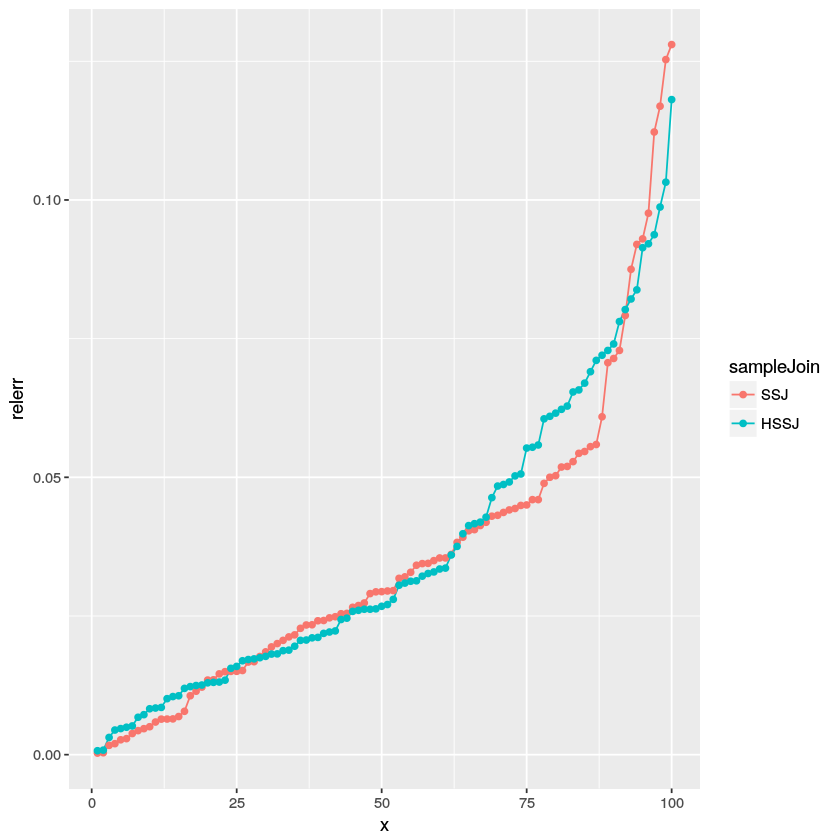

In [735]:
library(ggplot2)

data = rbind.data.frame(
            #cbind.data.frame(x=1:nrep,relerr=sort(raw_relerrors$NSJ), sampleJoin=replicate(nrep,"NSJ")),
            cbind.data.frame(x=1:nrep,relerr=sort(raw_relerrors$SSJ), sampleJoin=replicate(nrep,"SSJ")),
            cbind.data.frame(x=1:nrep,relerr=sort(raw_relerrors$HSSJ),sampleJoin=replicate(nrep,"HSSJ"))
        )
#p=plot_ly(data, x = ~x, y = ~NSJ, type = 'scatter', mode = 'lines')

ggplot(data,
       aes(x=x,
           y=relerr,
           color=sampleJoin))+
  geom_line()+geom_point()


#qplot(x = x, y = relerr, data = data, color = type)+coord_cartesian(xlim = c(0, 10))
